In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Hyperparameters for faster training.
BATCH_SIZE = 16
IMG_SIZE = (128, 128)  # Reduced resolution speeds processing.
DATASET_DIR = "/content/dataset"  # Root directory of your dataset

# Load training dataset.
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_DIR, "train"),
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Load test dataset.
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_DIR, "test"),
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

CLASS_NAMES = train_dataset.class_names
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES, "Number of classes:", NUM_CLASSES)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Classes: ['FAKE', 'REAL'] Number of classes: 2


In [ ]:
from tensorflow.keras import layers

# Simplified data augmentation: only horizontal flip.
simple_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal")
])

# Rescaling to normalize pixel values.
preprocess_input = layers.Rescaling(1./255)

def prepare_dataset(dataset, augment=False):
    AUTOTUNE = tf.data.AUTOTUNE
    def preprocess(image, label):
        image = tf.cast(image, tf.float32)
        image = preprocess_input(image)
        if augment:
            image = simple_augmentation(image)
        return image, label
    return dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

# Prepare the datasets.
train_ds = prepare_dataset(train_dataset, augment=True)
test_ds = prepare_dataset(test_dataset, augment=False)

# Use a small prefetch buffer to limit memory overhead.
train_ds = train_ds.prefetch(buffer_size=2)
test_ds = test_ds.prefetch(buffer_size=2)

In [ ]:
# Enable mixed precision.
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Mixed precision policy:", mixed_precision.global_policy())

Mixed precision policy: <DTypePolicy "mixed_float16">


In [ ]:
from tensorflow.keras import layers, models

def build_finetune_model(model_name, input_shape=(128, 128, 3), num_classes=NUM_CLASSES):
    if model_name == "EfficientNetB0":
        base_model = tf.keras.applications.EfficientNetB0(
            include_top=False, weights="imagenet", input_shape=input_shape)
    elif model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(
            include_top=False, weights="imagenet", input_shape=input_shape)
    elif model_name == "MobileNetV2":
        base_model = tf.keras.applications.MobileNetV2(
            include_top=False, weights="imagenet", input_shape=input_shape)
    else:
        raise ValueError("Unsupported model name")

    # Freeze the base model layers.
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    # Use the base model with training=False to maintain train-time consistency of BN layers.
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    # Final output layer producing predictions. When using mixed precision, force `float32` in activation.
    x = layers.Dense(num_classes)(x)
    outputs = tf.keras.layers.Activation("softmax", dtype="float32")(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
from tensorflow.keras import callbacks, optimizers

EPOCHS = 5   # Fewer epochs for quick iterations
history_dict = {}  # To store training history for each model

model_names = ["EfficientNetB0", "ResNet50", "MobileNetV2"]

for name in model_names:
    print(f"\nTraining {name} with Adam optimizer...\n")

    model = build_finetune_model(name)
    model.compile(optimizer=optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Setup callbacks to save the best model based on training loss.
    checkpoint_cb = callbacks.ModelCheckpoint(
        filepath=f'/content/{name}_Adam_best.h5',
        save_best_only=True, monitor='loss', verbose=1)
    earlystop_cb = callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    h = model.fit(
        train_ds,
        epochs=EPOCHS,
        callbacks=[checkpoint_cb, earlystop_cb],
        verbose=2
    )

    history_dict[name] = h.history

    # Evaluate on test dataset.
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"{name} -> Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}\n")


Training EfficientNetB0 with Adam optimizer...

Epoch 1/5

Epoch 1: loss improved from inf to 0.70587, saving model to /content/EfficientNetB0_Adam_best.h5


6250/6250 - 140s - 22ms/step - accuracy: 0.5015 - loss: 0.7059
Epoch 2/5

Epoch 2: loss improved from 0.70587 to 0.70488, saving model to /content/EfficientNetB0_Adam_best.h5


6250/6250 - 115s - 18ms/step - accuracy: 0.5052 - loss: 0.7049
Epoch 3/5

Epoch 3: loss improved from 0.70488 to 0.70393, saving model to /content/EfficientNetB0_Adam_best.h5


6250/6250 - 115s - 18ms/step - accuracy: 0.5080 - loss: 0.7039
Epoch 4/5

Epoch 4: loss improved from 0.70393 to 0.70385, saving model to /content/EfficientNetB0_Adam_best.h5


6250/6250 - 141s - 23ms/step - accuracy: 0.5101 - loss: 0.7038
Epoch 5/5

Epoch 5: loss improved from 0.70385 to 0.70330, saving model to /content/EfficientNetB0_Adam_best.h5


6250/6250 - 114s - 18ms/step - accuracy: 0.5122 - loss: 0.7033
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8461 - loss: 0.5881
EfficientNetB0 -> Test Loss: 0.7017 - Test Accuracy: 0.5000


Training ResNet50 with Adam optimizer...

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5

Epoch 1: loss improved from inf to 0.62177, saving model to /content/ResNet50_Adam_best.h5


6250/6250 - 130s - 21ms/step - accuracy: 0.6581 - loss: 0.6218
Epoch 2/5

Epoch 2: loss improved from 0.62177 to 0.58344, saving model to /content/ResNet50_Adam_best.h5


6250/6250 - 135s - 22ms/step - accuracy: 0.6964 - loss: 0.5834
Epoch 3/5

Epoch 3: loss improved from 0.58344 to 0.57255, saving model to /content/ResNet50_Adam_best.h5


6250/6250 - 141s - 23ms/step - accuracy: 0.7046 - loss: 0.5726
Epoch 4/5

Epoch 4: loss improved from 0.57255 to 0.56534, saving model to /content/ResNet50_Adam_best.h5


6250/6250 - 147s - 24ms/step - accuracy: 0.7098 - loss: 0.5653
Epoch 5/5

Epoch 5: loss improved from 0.56534 to 0.56162, saving model to /content/ResNet50_Adam_best.h5


6250/6250 - 138s - 22ms/step - accuracy: 0.7120 - loss: 0.5616
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7749 - loss: 0.4788
ResNet50 -> Test Loss: 0.5441 - Test Accuracy: 0.7444


Training MobileNetV2 with Adam optimizer...

Epoch 1/5

Epoch 1: loss improved from inf to 0.36093, saving model to /content/MobileNetV2_Adam_best.h5


6250/6250 - 116s - 19ms/step - accuracy: 0.8441 - loss: 0.3609
Epoch 2/5

Epoch 2: loss improved from 0.36093 to 0.34739, saving model to /content/MobileNetV2_Adam_best.h5


6250/6250 - 138s - 22ms/step - accuracy: 0.8524 - loss: 0.3474
Epoch 3/5

Epoch 3: loss improved from 0.34739 to 0.34570, saving model to /content/MobileNetV2_Adam_best.h5


6250/6250 - 108s - 17ms/step - accuracy: 0.8537 - loss: 0.3457
Epoch 4/5

Epoch 4: loss did not improve from 0.34570
6250/6250 - 109s - 18ms/step - accuracy: 0.8545 - loss: 0.3473
Epoch 5/5

Epoch 5: loss did not improve from 0.34570
6250/6250 - 142s - 23ms/step - accuracy: 0.8541 - loss: 0.3463
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8876 - loss: 0.2653
MobileNetV2 -> Test Loss: 0.3019 - Test Accuracy: 0.8733



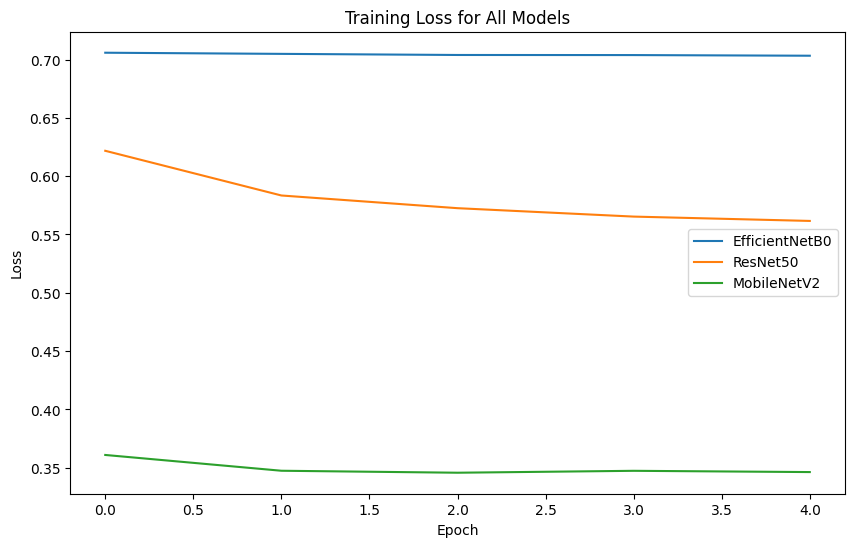

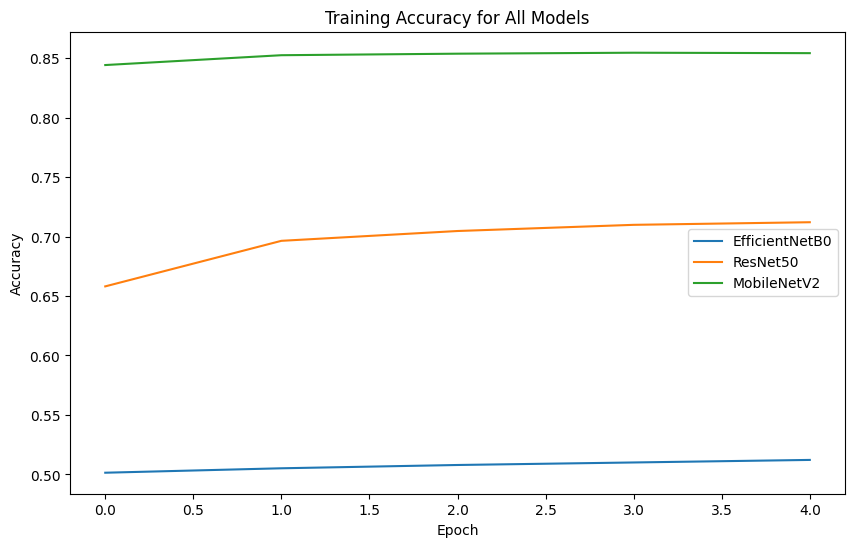

In [ ]:
import matplotlib.pyplot as plt

def plot_history(histories, metric, title):
    plt.figure(figsize=(10,6))
    for key, h in histories.items():
        plt.plot(h[metric], label=f'{key}')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

plot_history(history_dict, "loss", "Training Loss for All Models")
plot_history(history_dict, "accuracy", "Training Accuracy for All Models")